# Project 2

We're going to continue from where we left off with Project 1. Project 1 left us with a daily time series for every product with no gaps -- exactly what we want for modeling!

In [1]:
data_path = './data/project_2/'

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_parquet(f'{data_path}/sales_data.parquet')
data.head()

item_id  dept_id cat_id store_id  \
date       id                                                                  
2013-01-01 FOODS_1_004_TX_1_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_1   
           FOODS_1_004_TX_2_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_2   
           FOODS_1_004_TX_3_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_3   
           FOODS_1_005_TX_2_evaluation  FOODS_1_005  FOODS_1  FOODS     TX_2   
           FOODS_1_009_TX_2_evaluation  FOODS_1_009  FOODS_1  FOODS     TX_2   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_004_TX_1_evaluation       TX     20  
           FOODS_1_004_TX_2_evaluation       TX     20  
           FOODS_1_004_TX_3_evaluation       TX      4  
           FOODS_1_005_TX_2_evaluation       TX      1  
           FOODS_1_009_TX_2_evaluation       TX      3

In [4]:
data.shape

(11322748, 6)

We did some EDA in Project 1, but it was primarily focused on higher level patterns (i.e., at the department level). This time, spend some time doing EDA at the item level to see what kind of items you're dealing with.

Some questions you may want to explore:

1. How do high-volume items compare to low-volume/itermittent items?
2. What sort of seasonal patterns are at play?
3. Do items from different departments show different patterns?
4. Does the same item show different behavior at different stores?

These questions are just a starting point. Feel free to explore this any way you feel is necessary to make better models. The best EDA is done iteratively, so I encourage you to come back to this once you've started fitting models!

In [5]:
# do some EDA!


Before we get to modeling, let's create our evaluation setup. The models that we're going to create have a 28-day forecast horizon, and our goal is to best approximate "average" sales.

The first step is to implement our evaluation metric. The original competition used a metric called RMSSE, or "Root Mean Squared Scaled Error." It's similar to the MASE metric that we discussed before, except that the metric optimizes better for "average" sales (as opposed to MASE, which optimizes for the median, since it's an absolute error metric). The competition actually used a weighted version of RMSSE which is techincally more robust, but we're going to stick to RMSSE. Here's what RMSSE looks like:

$RMSSE = \sqrt{\frac{1}{h}\frac{\sum^{n+h}_{t=n+1} (Y_t - \hat{Y}_t)^2}{\frac{1}{n-1}\sum^n_{t=2} (Y_t - Y_{t-1})^2}}$

where $Y_t$ is the actual future value of sales at date $t$, $\hat{Y}_t$ is your forecast for date $t$, $n$ is the number of dates in our training set, and $h$ is our forecast horizon (28 days, in our case).

That looks intimidating! But, similarly to MASE, you can break it down into two parts:
- The numerator: $\frac{1}{h}\sum^{n+h}_{t=n+1} (Y_t - \hat{Y}_t)^2$, which is just the MSE for every prediction in the validation set.
- The denominator: $\frac{1}{n-1}\sum^n_{t=2} (Y_t - Y_{t-1})^2$, which is just the MSE over the entire training set if your forecast was a naive, one-day-ahead forecast. We refer to this as the "scale" since it's really just a benchmark -- errors less than this are better than the benchmark, and errors greater than this are worse.

Of course, the "naive, one-day-ahead forecast" part only works if you calculate both the numerator and denominator separately for each `id`. So, the idea here is that you are effectively calculating an RMSSE value for each `id`, and then averaging those to get the final RMSSE.

Last comment: there are products in the dataset that don't start showing sales for some time. For those products, the denominator is only supposed to be calculated after the first sale in the dataset. I'd recommend just dropping the records for those products until that first sales, which is straightforward to do using `.cumsum()` over `sales` while grouping by `id`.

In [6]:
# QUESTION: filter out products that don't have sales using cumsum
data = data[data.groupby('id')['sales'].cumsum() > 0]

/tmp/ipykernel_8345/2549296341.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[data.groupby('id')['sales'].cumsum() > 0]


Here's how you should implement your RMSSE:

1. Create a function called `rmsse` that looks like this:

`def rmsse(train, val, y_pred):`

where:
- `train` is the `pd.DataFrame` representing the training set
- `val` is the `pd.DataFrame` representing the validation set
- `y_pred` is either a `pd.Series` or `np.ndarray` that is the output of your model

2. Start by calculating the scale (i.e. denominator from above) for each `id` over the training set.

3. Then, calculate the MSE for each `id` over the validation set.

4. Merge the scale dataframe onto the dataframe that contains your validation MSE values.

5. Use the merged dataframe to calculate the RMSSE for each `id`, and finally return the average of all of those RMSSE values.

Don't worry that you haven't split your data into training and validation sets yet. I gave you a test case below to see if your code is working before you move on. Also, don't be afraid to do this in a simple, looped fashion before refactoring it into more beautiful Pandas code. Take advantage of that test case!

*Note:* If you're stuck, check the project instructions for the answer!

In [51]:
def rmsse(train, val, y_pred):
    train_scale = (
        train
        .assign(
            scale=train.groupby('id', observed=True).sales.diff() ** 2,
        )
        .groupby('id', observed=True)
        .scale
        .mean()
    )
    
    score = (
        val
        .assign(squared_error=(val.sales - y_pred) ** 2)
        .groupby('id', observed=True)
        .squared_error
        .mean()
        .to_frame()
        .merge(train_scale, on='id')
        .assign(rmsse=lambda x: np.sqrt(x.squared_error / x.scale))
        .rmsse
        .mean()
    )

    return score

In [8]:
def test_rmsse():
    test_train = pd.DataFrame({
        'id': ['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c'],
        'sales': [3, 2, 5, 100, 150, 60, 10, 20, 30],
    })
    test_val = pd.DataFrame({
        'id': ['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c'],
        'sales': [6, 1, 4, 200, 120, 270, 10, 20, 30],
    })
    test_y_pred = pd.Series([1, 2, 3, 180, 160, 240, 20, 30, 40])

    assert np.abs(rmsse(test_train, test_val, test_y_pred) - 0.92290404515501) < 1e-6

test_rmsse()

# Fitting models

Now it's time to fit a LightGBM model. You'll be fitting a single model that predicts 28 days into the future. Remember to focus less on hyperparameter tuning and a lot more on the data and your features.

Feature engineering can be tricky! I'd recommend giving it a shot yourself, but if you get stuck, remember that I provided code to calculate rolling and lagged features in the course modules.

Remember to also use the external datasets that I provided, they'll be very useful!

Here's some sample feature engineering code to get started with:

In [9]:
data = data.reset_index()

In [10]:
calendar = pd.read_parquet(f"{data_path}calendar.parquet")
prices = pd.read_parquet(f"{data_path}prices.parquet")

In [11]:
data = data.merge(calendar, on='date', how='left')
data = data.merge(prices, on=['date', 'item_id', 'store_id'], how='left')

In [12]:
from sklearn.preprocessing import OrdinalEncoder

In [13]:
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

In [14]:
data[cat_cols] = OrdinalEncoder(dtype='int').fit_transform(data[cat_cols])

In [15]:
data['dayofweek'] = data['date'].dt.day_of_week
data['dayofyear'] = data['date'].dt.day_of_year
data['dayofmonth'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['week'] = data['date'].dt.isocalendar().week.astype('int')
data['quarter'] = data['date'].dt.quarter

In [16]:
#RBF seasonality
from sklego.preprocessing import RepeatingBasisFunction

rbf_features_list = []
time_cols = ['dayofweek', 'dayofyear', 'dayofmonth', 'month', 'year', 'week', 'quarter']
for col in time_cols:
    min_val = data[col].min()
    max_val = data[col].max()
    rbf_encoder = RepeatingBasisFunction(n_periods=3,
                                         column=col,
                                         input_range=(min_val, max_val),
                                         remainder='drop',
                                         width=0.25)
    rbf_features = rbf_encoder.fit_transform(data)
    rbf_features_df = pd.DataFrame(rbf_features,
                                   columns=[f'RBF_{col}_{i}'
                                            for i in range(rbf_features.shape[1])])
    rbf_features_list.append(rbf_features_df)

rbf_features_df = pd.concat(rbf_features_list, axis=1)

In [17]:
#Fourier seasonality
from sktime.transformations.series.fourier import FourierFeatures

fourier = FourierFeatures(sp_list=[4, 12, 53, 7],
                          fourier_terms_list=[3, 3, 3, 3],
                          keep_original_columns=False)
fourier_feats = fourier.fit_transform(pd.Series(data.index))


/home/ubuntu/.venv/lib/python3.10/site-packages/sktime/transformations/base.py:486: UserWarning: The terms sin_12_3 and cos_12_3 from FourierFeatures will be skipped because the resulting coefficient already exists from other seasonal period, fourier term pairs.
  self._fit(X=X_inner, y=y_inner)


In [18]:
data = pd.concat([data, rbf_features_df, fourier_feats], axis=1)

In [19]:
features = data.drop(columns=['sales', 'date', 'id']).columns.tolist()

In [20]:
data = data.set_index(['date'])

In [35]:
def calc_lag(df, shift_length, forecast_horizon, by_day_of_week=False):
    group_cols = ['id']
    if by_day_of_week:
        group_cols.append('dayofweek')

    feature_name = f'lag_{shift_length}_{forecast_horizon}'

    return (
        df
        .groupby(group_cols, observed=True)
        .sales
        .shift(forecast_horizon + shift_length)
        .rename(feature_name)
        .reset_index()
        
    ), feature_name
    
def calc_rolling_agg(df, window_length, forecast_horizon, agg_func='mean', by_day_of_week=False):
    group_cols = ['id']
    if by_day_of_week: group_cols += ['dayofweek']
    

    if not by_day_of_week:
        feature_name = f'rolling_{agg_func}_{window_length}_{forecast_horizon}'
    else:
        feature_name = f'seasonal_rolling_{agg_func}_{window_length}_{forecast_horizon}'

    return (
        df
        .groupby(group_cols, group_keys=False, observed=True)
        .sales
        .rolling(window_length, closed='right', min_periods=1) # only requires 1 observation to be non-NaN
        .agg({'sales': agg_func})
        .reset_index()
        .assign(date=lambda x: x.date + pd.Timedelta(days=28))
        .set_index('date')
        .rename(columns={'sales': feature_name})
    ), feature_name

In [36]:
forecast_horizon = 28

lag_features = [1, 7, 14, 28]

rolling_features = {
     'mean': [7, 14, 28],
     'std': [7, 14, 28],
     'min': [7, 14, 28],
     'max': [7, 14, 28],
}

seasonal_rolling_features = {
     'mean': [7, 14, 28],
     'std': [7, 14, 28],
     'min': [7, 14, 28],
     'max': [7, 14, 28],
}


In [46]:
def feature_engineering(df, features, forecast_horizon):
    # This is just an example template to give you an idea of what to do

    for lag in lag_features:
        feature_series_lag, feature_name = calc_lag(df, lag, forecast_horizon)
        features.append(feature_name)
        df = pd.concat([df, feature_series_lag.set_index('date')], axis=1)
    print('Lagged calclulated')
    
    for agg_func, windows in rolling_features.items():
        for w in windows:
            feature_series, feature_name = calc_rolling_agg(df, w, agg_func)
            features.append(feature_name)
            df = df.merge(feature_series, on=['date', 'id'], how='left')
    print('Rolling calculated')
    
    for agg_func, windows in seasonal_rolling_features.items():
        for w in windows:
            feature_series, feature_name = calc_rolling_agg(df, w, agg_func, by_day_of_week=True)
            features.append(feature_name)
            df = df.merge(feature_series.drop(columns='dayofweek'), on=['date', 'id'], how='left')
            
    print('Seasonal rolling caluclated')


    # calculate other features, such as date features, grouped aggregations,
    # price features, etc.
    horizon = df.index[-1] - pd.Timedelta(days=29)

    train = df.loc[:horizon]
    val = df.loc[horizon + pd.Timedelta(days=1):]
    features = pd.Series(features).drop_duplicates().tolist()
    # change this as needed
    return train, val, features

And some sample model fitting code:

In [47]:
import lightgbm as lgb

# some parameters to play around with. Not the best by any means!
params = dict(
    objective='tweedie',
    tweedie_variance_power=1.1,
    learning_rate=0.05,
    min_samples_leaf=100,
    subsample=0.3,
    feature_fraction=0.3,
    deterministic=True,
)

train, val, features = feature_engineering(data, features, forecast_horizon)

train_dset = lgb.Dataset(
    train[features], 
    train['sales'],
)

val_dset = lgb.Dataset(
    val[features], 
    val['sales'],
)


Lagged calclulated
Rolling calculated
Seasonal rolling caluclated


In [52]:
callbacks = [
    lgb.early_stopping(100),
    lgb.log_evaluation(50)
]

model = lgb.train(
    params, 
    train_dset,
    num_boost_round=1000,
    valid_sets=[val_dset],
    callbacks=callbacks,
)

preds = model.predict(val[features])
print(f'RMSSE: {rmsse(train, val, preds)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13784
[LightGBM] [Info] Number of data points in the train set: 10033345, number of used features: 88
[LightGBM] [Info] Start training from score 0.224924
Training until validation scores don't improve for 100 rounds
[50]	valid_0's tweedie: 12.9636
[100]	valid_0's tweedie: 12.957
[150]	valid_0's tweedie: 12.9562
[200]	valid_0's tweedie: 12.9554
[250]	valid_0's tweedie: 12.9557
Early stopping, best iteration is:
[169]	valid_0's tweedie: 12.9554
RMSSE: 0.7546162627794605


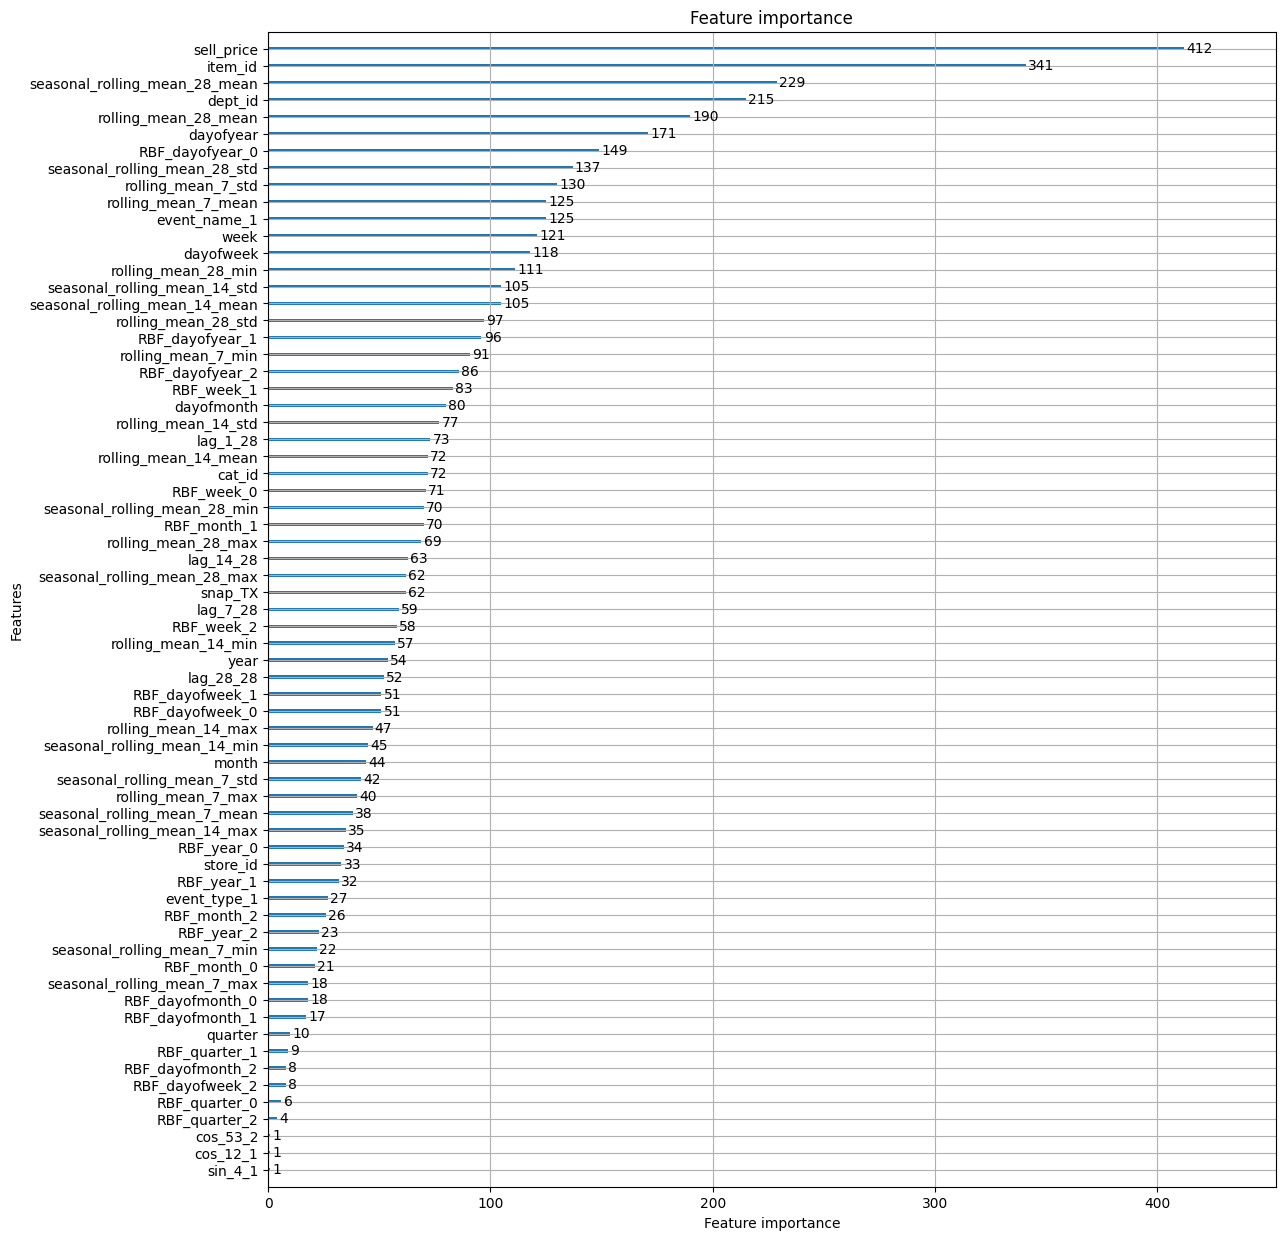

In [59]:
lgb.plot_importance(model, figsize=(13, 15));